# How to use the logaddexp special function in fits

The logaddexp special function was made to perform this calculation more accurately:
$$
y = \ln(\exp(a) + \exp(b)).
$$
This calculation occurs when we fit a mixed PDF with two components to a data sample, and both components can be modeled with PDFs from the exponential family. In that case, one can compute $a$ and $b$ efficiently, which represent the log-probability-density. This is not artificial, the normal, student's t, and exponential distributions are from the exponential family.

Because of the finite dynamic range of floating point numbers and round-off, this computation can become inaccurate or yield infinity. One can avoid these issues by first determining whether $a$ or $b$ is larger and then by factoring it out of the equation. The [logaddexp special function](https://numpy.org/doc/stable/reference/generated/numpy.logaddexp.html) implements this strategy.

We explore this based on a toy example of a signal peak sampled from the student's t distribution over an exponential background.

In [21]:
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
from numba_stats import t, truncexpon, expon
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

This is our toy data sample that we wish to fit.

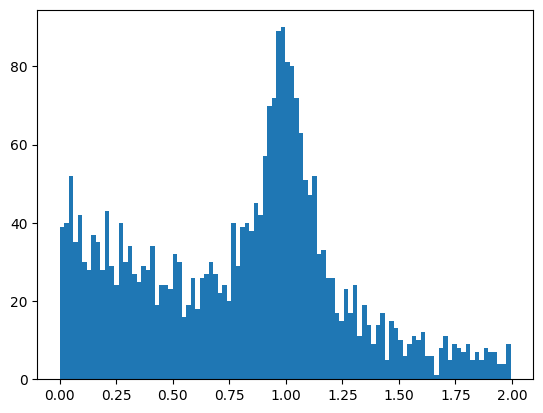

In [22]:
rng = np.random.default_rng(1)

x = 0.1 * rng.standard_t(2, size=1000) + 1
x = np.append(x, rng.exponential(size=2000))
x = x[(0 < x) & (x < 2)]

plt.hist(x, bins=100);

As a reference, we first run the standard fit without logaddexp.

In [23]:
def model(x, ns, df, mu, sigma, nb, tau):
    return ns + nb, ns * t.pdf(x, df, mu, sigma) + nb * truncexpon.pdf(
        x, 0, 2, 0, tau)


cost = ExtendedUnbinnedNLL(x, model)

m = Minuit(cost, ns=1000, nb=2000, df=2, mu=1, sigma=0.1, tau=1)
m.limits["ns", "nb", "sigma", "tau"] = (0, None)
m.limits["df"] = (1, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -3.516e+04                 │              Nfcn = 170              │
│ EDM = 8.76e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns    │    930    │    50     │            │            │    0    │         │       │
│ 1 │ df    │    3.9    │    1.0    │            │            │    1    │         │       │
│ 2 │ mu    │   0.997   │   0.005   │            │            │         │         │       │
│ 3 │ sigma │   0.103   │   0.006   │            │            │    0    │         │       │
│ 4 │ nb    │  1.80e3   │  0.06e3   │            │            │    0    │         │       │
│ 5 │ tau   │   1.04    │   0.05    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────────────────┐
│       │         ns         df         mu      sigma         nb        tau │
├───────┼───────────────────────────────────────────────────────────────────┤
│    ns │   2.35e+03      -15.2  -9.210e-3  111.09e-3     -1.4e3    -0.8988 │
│    df │      -15.2       1.12   0.051e-3    2.40e-3       15.2     0.0098 │
│    mu │  -9.210e-3   0.051e-3   2.78e-05  -0.001e-3   9.206e-3  -0.023e-3 │
│ sigma │  111.09e-3    2.40e-3  -0.001e-3    4.2e-05 -111.06e-3   -0.07e-3 │
│    nb │     -1.4e3       15.2   9.206e-3 -111.06e-3   3.22e+03     0.8986 │
│   tau │    -0.8988     0.0098  -0.023e-3   -0.07e-3     0.8986    0.00296 │
└───────┴───────────────────────────────────────────────────────────────────┘

Calling the `logpdf` methods for the two component PDFs is computationally more efficient than the `pdf` methods. 

In [24]:
%%timeit
t.logpdf(x, 2, 0, 1)

27.8 µs ± 491 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [25]:
%%timeit
t.pdf(x, 2, 0, 1)

43.8 µs ± 3.19 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [26]:
%%timeit
truncexpon.logpdf(x, 0, 2, 0, 1)

8.12 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [27]:
%%timeit
truncexpon.pdf(x, 0, 2, 0, 1)

21.4 µs ± 382 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Now we run the fit again using the `logpdf` methods of the component distributions and `logaddexp`. Our model now returns the log-probability and we notify the `ExtendedUnbinnedNLL` cost function of that fact with the keyword `log=True`.

In [35]:
def model_log(x, ns, df, mu, sigma, nb, tau):
    return ns + nb, np.logaddexp(
        np.log(ns) + t.logpdf(x, df, mu, sigma),
        np.log(nb) + truncexpon.logpdf(x, 0, 2, 0, tau))


cost_log = ExtendedUnbinnedNLL(x[(0 < x) & (x < 2)], model_log, log=True)

m_log = Minuit(cost_log, ns=1000, nb=2000, df=2, mu=1, sigma=0.1, tau=1)
m_log.limits["ns", "nb", "sigma", "tau"] = (0, None)
m_log.limits["df"] = (1, None)
m_log.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -3.516e+04                 │              Nfcn = 170              │
│ EDM = 8.76e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns    │    930    │    50     │            │            │    0    │         │       │
│ 1 │ df    │    3.9    │    1.0    │            │            │    1    │         │       │
│ 2 │ mu    │   0.997   │   0.005   │            │            │         │         │       │
│ 3 │ sigma │   0.103   │   0.006   │            │            │    0    │         │       │
│ 4 │ nb    │  1.80e3   │  0.06e3   │            │            │    0    │         │       │
│ 5 │ tau   │   1.04    │   0.05    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────────────────┐
│       │         ns         df         mu      sigma         nb        tau │
├───────┼───────────────────────────────────────────────────────────────────┤
│    ns │   2.35e+03      -15.2  -9.210e-3  111.09e-3     -1.4e3    -0.8988 │
│    df │      -15.2       1.12   0.051e-3    2.40e-3       15.2     0.0098 │
│    mu │  -9.210e-3   0.051e-3   2.78e-05  -0.001e-3   9.206e-3  -0.023e-3 │
│ sigma │  111.09e-3    2.40e-3  -0.001e-3    4.2e-05 -111.06e-3   -0.07e-3 │
│    nb │     -1.4e3       15.2   9.206e-3 -111.06e-3   3.22e+03     0.8986 │
│   tau │    -0.8988     0.0098  -0.023e-3   -0.07e-3     0.8986    0.00296 │
└───────┴───────────────────────────────────────────────────────────────────┘

As expected, the results are identical up to round-off error. However, the computation should now be more numerically stable. Despite the fact that the logpdf is faster to compute, computing the log-likelihood is a bit slower. It is possible that the branch inside logaddexp slows down the computation.

In [30]:
%%timeit
cost(*m.values)

113 µs ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [31]:
%%timeit
cost_log(*m_log.values)

140 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


It is difficult to show that the second computation is more numerically stable. I make an attempt here by running the fit many times with variable starting values. This should lead to a valid more often if the computation is numerically stable. However, both versions of the fit perform equally well in this test.

In [77]:
rng = np.random.default_rng(1)
valids = np.empty((100, 2), dtype=bool)
for i in range(len(valids)):
    m.reset()
    m_log.reset()

    ns = rng.exponential(1000)
    df = 1 + rng.exponential(1)
    mu = rng.normal(1, 0.25)
    sigma = rng.exponential(0.1) + 0.01
    nb = rng.exponential(2000)
    tau = rng.exponential(1)

    m.values = (ns, df, mu, sigma, nb, tau)
    m.migrad()

    m_log.values = (ns, df, mu, sigma, nb, tau)
    m_log.migrad()

    valids[i, 0] = m.valid
    valids[i, 1] = m_log.valid
print(np.mean(valids, axis=0))

[0.99 0.99]


The reason for this is that `ExtendedUnbinnedNLL` has some tricks (mostly the safe_log) which make sure that the simpler, less numerically stable, calculation also works most of the time.